Average Skill Ratings by Department and Level:
{'Data Science': {'Lead': {'ML': 1.4035087719298245, 'DL': 1.1140350877192982, 'Python': 2.5701754385964914, 'Statistics': 1.2105263157894737, 'Data Wrangling': 1.1666666666666667, 'R': 1.3245614035087718}, 'Senior Analyst': {'ML': 0.2857142857142857, 'DL': 0.2857142857142857, 'Python': 1.9523809523809523, 'Statistics': 0.5238095238095238, 'Data Wrangling': 0.23809523809523808, 'R': 0.38095238095238093}, 'Analyst': {'ML': 3.066666666666667, 'DL': 1.8666666666666667, 'Python': 1.5333333333333334, 'Statistics': 3.0, 'Data Wrangling': 2.4, 'R': 2.8666666666666667}}, 'Marketing': {'Lead': {'SEO': 1.0087719298245614, 'Content Creation': 1.0789473684210527, 'Analytics': 1.0526315789473684, 'Social Media': 0.956140350877193, 'Brand Management': 1.0, 'Market Research': 0.9824561403508771}, 'Senior Analyst': {'SEO': 1.7619047619047619, 'Content Creation': 1.380952380952381, 'Analytics': 1.7619047619047619, 'Social Media': 1.5714285714285714, 'Brand

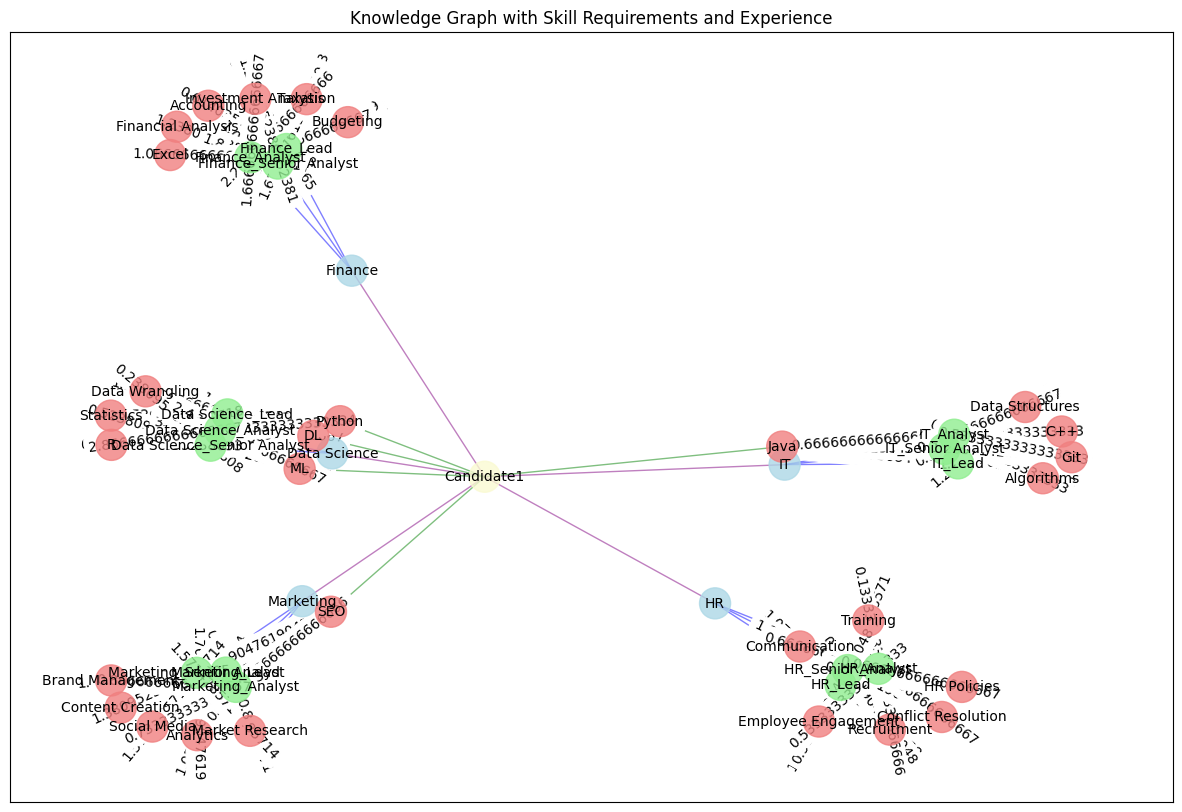

In [25]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('employee_skills_ratings_V3.csv')

# Define the departments and levels
departments = ['Data Science', 'Marketing', 'Finance', 'HR', 'IT']
levels = ['Lead', 'Senior Analyst', 'Analyst']
data['Current_Level'] = np.random.choice(levels, size=len(data))

# Assign current level based on the total years of experience in all departments
def assign_level(total_experience):
    if total_experience >= 10:
        return 'Lead'
    elif total_experience >= 5:
        return 'Senior Analyst'
    else:
        return 'Analyst'

# Assign realistic years of experience for each department
def assign_experience(level):
    if level == 'Lead':
        return np.random.randint(5, 10)  # 5 to 10 years
    elif level == 'Senior Analyst':
        return np.random.randint(3, 5)   # 3 to 5 years
    else:
        return np.random.randint(0, 3)    # 0 to 3 years

# Assign years of experience for each department
for dept in departments:
    data[f'{dept}_exp'] = data['Current_Level'].apply(assign_experience)

# Calculate total years of experience
data['Total_Experience'] = data[[f'{dept}_exp' for dept in departments]].sum(axis=1)

# Assign Current_Level based on Total_Experience
data['Current_Level'] = data['Total_Experience'].apply(assign_level)

# Define the relevant skills for each department
department_skills = {
    'Data Science': ['ML', 'DL', 'Python', 'Statistics', 'Data Wrangling', 'R'],
    'Marketing': ['SEO', 'Content Creation', 'Analytics', 'Social Media', 'Brand Management', 'Market Research'],
    'Finance': ['Accounting', 'Financial Analysis', 'Excel', 'Budgeting', 'Taxation', 'Investment Analysis'],
    'HR': ['Recruitment', 'Training', 'Communication', 'Conflict Resolution', 'Employee Engagement', 'HR Policies'],
    'IT': ['Java', 'C++', 'Algorithms', 'Data Structures', 'Git']
}

# Initialize dictionaries to store average skill ratings and experience
average_skills = {dept: {} for dept in departments}
average_experience = {dept: {} for dept in departments}

# Calculate the averages based on department and seniority level
for dept in departments:
    for level in levels:
        relevant_data = data[data['Current_Level'] == level]
        if not relevant_data.empty:
            avg_skills = relevant_data[department_skills[dept]].mean().to_dict()
            avg_exp = relevant_data[f'{dept}_exp'].mean()

            average_skills[dept][level] = avg_skills
            average_experience[dept][level] = avg_exp

print("Average Skill Ratings by Department and Level:")
print(average_skills)
print("\nAverage Years of Experience by Department and Level:")
print(average_experience)

# Function to build the knowledge graph
def build_knowledge_graph(departments_skills, employee):
    G = nx.Graph()

    # Add department nodes and their skills with required ratings
    for dept, levels_skills in departments_skills.items():
        G.add_node(dept, type='Department')
        for level, skills in levels_skills.items():
            level_node = f"{dept}_{level}"
            G.add_node(level_node, type='SeniorityLevel', level=level)
            G.add_edge(dept, level_node, type='RequiresSkill')

            for skill, required_rating in skills.items():
                G.add_node(skill, type='Skill')
                G.add_edge(level_node, skill, required_rating=required_rating, type='RequiredSkill')

    # Add employee node
    G.add_node(employee['name'], type='Employee')

    # Add edges for the employee's skills and their ratings
    for skill, rating in employee['skills'].items():
        if G.has_node(skill):
            G.add_edge(employee['name'], skill, rating=rating, type='Skill')

    # Add edges for the employee's experience in departments
    for dept in departments_skills.keys():
        dept_exp_key = f"{dept}_exp"
        if dept_exp_key in employee['experience']:
            G.add_edge(employee['name'], dept, experience=employee['experience'][dept_exp_key], type='Experience')

    return G

# Function to evaluate fit with graph
# def evaluate_fit_with_graph(G, departments_skills, candidate_node='Candidate'):
#     print("#####################################")
#     best_department = None
#     best_match_score = float('-inf')
#     best_fit_details = {}

#     for department in [n for n, d in G.nodes(data=True) if d['type'] == 'Department']:
#         for level, required_skills in departments_skills[department].items():
#             print("***************************************")
#             print(department, level)
#             matching_skills = {}
#             missing_skills = {}
#             skills_to_improve = {}

#             # Calculate delta and skill scores
#             delta = 0
#             total_required_rating = sum(required_skills.values())
#             for skill, required_rating in required_skills.items():
#                 print(skill, required_rating)
#                 if G.has_edge(candidate_node, skill) and G.edges[candidate_node, skill]['type'] == 'Skill':
#                     candidate_rating = G.edges[candidate_node, skill]['rating']
#                     delta += abs(required_rating - candidate_rating)
#                     if candidate_rating >= required_rating:
#                         matching_skills[skill] = candidate_rating
#                     else:
#                         skills_to_improve[skill] = (candidate_rating, required_rating)
#                 else:
#                     missing_skills[skill] = required_rating

#             # Normalize delta by total required rating
#             if total_required_rating > 0:
#                 delta /= total_required_rating

#             # Experience score
#             experience_score = 0
#             if G.has_edge(candidate_node, department) and G.edges[candidate_node, department]['type'] == 'Experience':
#                 experience_years = G.edges[candidate_node, department]['experience']
#                 avg_exp = average_experience[department][level]
#                 experience_score = min(experience_years / avg_exp, 1)  # Normalize by average experience

#             # Calculate the combined match score

#             skill_weight = 0.7
#             seniority_weight = 0.3
#             print("match_score = skill_weight * (1 - delta) + seniority_weight * experience_score")
#             print(skill_weight, delta,seniority_weight,experience_score)
#             match_score = skill_weight * (1 - delta) + seniority_weight * experience_score
#             print(match_score)

#             if match_score > best_match_score:
#                 best_match_score = match_score
#                 best_department = department
#                 best_fit_details = {
#                     "matching_skills": matching_skills,
#                     "missing_skills": missing_skills,
#                     "skills_to_improve": skills_to_improve,
#                     "skill_score": 1 - delta,
#                     "experience_score": experience_score
#                 }

#     return best_department, best_fit_details


# Function to evaluate fit with graph, including total years of experience
def evaluate_fit_with_graph(G, departments_skills, candidate_node='Candidate'):
    best_department = None
    best_match_score = float('-inf')
    best_fit_details = {}

    # Get the total experience of the candidate
    if G.has_node(candidate_node):
        total_experience = sum([G.edges[candidate_node, dept]['experience'] for dept in departments_skills if G.has_edge(candidate_node, dept) and G.edges[candidate_node, dept]['type'] == 'Experience'])
    else:
        total_experience = 0

    for department in [n for n, d in G.nodes(data=True) if d['type'] == 'Department']:
        for level, required_skills in departments_skills[department].items():
            print("*********************************************")
            print(department,level)
            matching_skills = {}
            missing_skills = {}
            skills_to_improve = {}

            # Calculate delta and skill scores
            delta = 0
            total_required_rating = sum(required_skills.values())
            for skill, required_rating in required_skills.items():

                if G.has_edge(candidate_node, skill) and G.edges[candidate_node, skill]['type'] == 'Skill':
                    candidate_rating = G.edges[candidate_node, skill]['rating']
                    delta += abs(required_rating - candidate_rating)
                    if candidate_rating >= required_rating:
                        matching_skills[skill] = candidate_rating
                    else:
                        skills_to_improve[skill] = (candidate_rating, required_rating)
                else:
                    missing_skills[skill] = required_rating

            # Normalize delta by total required rating
            if total_required_rating > 0:
                delta /= total_required_rating

            # Experience score
            experience_score = 0
            if G.has_edge(candidate_node, department) and G.edges[candidate_node, department]['type'] == 'Experience':
                experience_years = G.edges[candidate_node, department]['experience']
                avg_exp = average_experience[department][level]
                experience_score = min(experience_years / avg_exp, 1)  # Normalize by average experience

            # Total Experience score (weighted)
            total_experience_score = min(total_experience / 10, 1)  # Assuming a maximum of 10 years for scaling

            # Calculate the combined match score
            skill_weight = 0.5
            seniority_weight = 0.3
            total_experience_weight = 0.2
            match_score = skill_weight * (1 - delta) + seniority_weight * experience_score + total_experience_weight * total_experience_score
            print("match_score = skill_weight * (1 - delta) + seniority_weight * experience_score + total_experience_weight * total_experience_score")
            print(skill_weight, delta,seniority_weight,experience_score,total_experience_weight,total_experience_score)
            print(match_score)
            if match_score > best_match_score:
                best_match_score = match_score
                best_department = department
                best_fit_details = {
                    "matching_skills": matching_skills,
                    "missing_skills": missing_skills,
                    "skills_to_improve": skills_to_improve,
                    "skill_score": 1 - delta,
                    "experience_score": experience_score,
                    "total_experience_score": total_experience_score
                }

    return best_department, best_fit_details


# Example data for a new employee
new_employee = {
    'name': 'Candidate1',
    'skills': {'ML': 9, 'DL': 4, 'Python': 5, 'SEO': 2, 'Java': 4},
    'experience': {'Data Science_exp': 3, 'Marketing_exp': 1, 'Finance_exp': 0, 'HR_exp': 2, 'IT_exp': 4}
}

# Build the knowledge graph
G = build_knowledge_graph(average_skills, new_employee)

# Evaluate fit and get recommendations
best_department, fit_details = evaluate_fit_with_graph(G, average_skills, candidate_node=new_employee['name'])

# Print the results
print("Best Department:", best_department)
print("Fit Details:", fit_details)

# Visualization of the Knowledge Graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)

# Define colors for different node types
node_colors = {
    'Department': 'lightblue',
    'SeniorityLevel': 'lightgreen',
    'Skill': 'lightcoral',
    'Employee': 'lightgoldenrodyellow'
}
edge_colors = {
    'RequiresSkill': 'blue',
    'RequiredSkill': 'red',
    'Skill': 'green',
    'Experience': 'purple'
}

# Draw nodes with different colors
node_type_colors = [node_colors[G.nodes[n]['type']] for n in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_type_colors, alpha=0.8)

# Draw edges with different colors
edge_type_colors = [edge_colors.get(G.edges[e]['type'], 'black') for e in G.edges]
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color=edge_type_colors)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
edge_labels = nx.get_edge_attributes(G, 'required_rating')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')

plt.title("Knowledge Graph with Skill Requirements and Experience")
plt.show()


In [12]:
# Function to print nodes of a subgraph centered around a selected department
def print_subgraph_nodes(G, department):
    # Get all nodes connected to the department
    nodes = set([department])
    nodes.update(nx.node_connected_component(G, department))

    # Create the subgraph
    subgraph = G.subgraph(nodes)

    # Print nodes
    print(f"Nodes in the subgraph for Department: {department}")
    for node in subgraph.nodes:
        node_type = subgraph.nodes[node].get('type', 'Unknown')
        print(f"Node: {node}, Type: {node_type}")

# Print nodes for the best department
print_subgraph_nodes(G, best_department)

Nodes in the subgraph for Department: HR
Node: Data Science, Type: Department
Node: Data Science_Lead, Type: SeniorityLevel
Node: ML, Type: Skill
Node: DL, Type: Skill
Node: Python, Type: Skill
Node: Statistics, Type: Skill
Node: Data Wrangling, Type: Skill
Node: R, Type: Skill
Node: Data Science_Senior Analyst, Type: SeniorityLevel
Node: Data Science_Analyst, Type: SeniorityLevel
Node: Marketing, Type: Department
Node: Marketing_Lead, Type: SeniorityLevel
Node: SEO, Type: Skill
Node: Content Creation, Type: Skill
Node: Analytics, Type: Skill
Node: Social Media, Type: Skill
Node: Brand Management, Type: Skill
Node: Market Research, Type: Skill
Node: Marketing_Senior Analyst, Type: SeniorityLevel
Node: Marketing_Analyst, Type: SeniorityLevel
Node: Finance, Type: Department
Node: Finance_Lead, Type: SeniorityLevel
Node: Accounting, Type: Skill
Node: Financial Analysis, Type: Skill
Node: Excel, Type: Skill
Node: Budgeting, Type: Skill
Node: Taxation, Type: Skill
Node: Investment Analysis,